In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
workers=7
random_crop=True
pseudo_label=False
use_val=False

In [8]:
S_PREFIX = '32-dicew-crop'

In [9]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [10]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
        
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [11]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [12]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [13]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [14]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [15]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [16]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [18]:
def convert_y(y_img):
    yr = (y_img==ROADS) | (y_img==ROAD_LINES)
    yc = (y_img==VEHICLES)
    cutoff_y = int(yc.shape[0]*.87)
    yc[cutoff_y:,:] = 0
    return torch.from_numpy(np.stack((yc,yr)).astype(int))


def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [19]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, x, y):
        i, j, h, w = self.get_params(x, self.scale, self.ratio)
        x = TTF.resized_crop(x, i, j, h, w, self.size, self.interpolation)
        y = TTF.resized_crop(y, i, j, h, w, self.size, self.interpolation)
        return x, y

In [20]:
def torch_loader(f_ext, data_path, bs, size, workers=7, random_crop=False, pseudo_label=False, use_val=False):
    # Data loading code
    x_names = np.sort(np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png'))))
    y_names = np.sort(np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png'))))

    x_n = x_names.shape[0]
    val_idxs = list(range(x_n-300, x_n))
    
    if pseudo_label:
        x_names_test = np.sort(np.array(glob(f'../data/TestData/CameraRGB{f_ext}/*.png')))
        y_names_test = np.sort(np.array(glob(f'../data/TestData/CameraSeg{f_ext}/*.png')))
        x_names = np.concatenate((x_names, x_names_test))
        x_names = np.concatenate((y_names, y_names_test))
        print(f'Pseudo-Labels: {len(x_names_test)}')
    if use_val:
        x_names_val = np.sort(np.array(glob(f'../data/val/CameraRGB{f_ext}/*.png')))
        y_names_val = np.sort(np.array(glob(f'../data/val/CameraSeg{f_ext}/*.png')))
        val_x,val_y = x_names_val, y_names_val
        trn_x,trn_y = x_names, y_names
        print(f'Val Labels:', len(val_x))
    else:
        ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    print(f'Val x:{len(val_x)}, y:{len(val_y)}')
    print(f'Trn x:{len(trn_x)}, y:{len(trn_y)}')
    print(f'All x:{len(x_names)}')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((size,size)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    if random_crop:
        train_tfms.insert(3,RRC(size, scale=(0.4, 1.0)))
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [21]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

In [22]:
sz = 96
bs = 2
ext = '-150'
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, use_val)

Val x:300, y:300
Trn x:6980, y:6980
All x:7280


In [23]:
x,y = data.trn_ds[800]

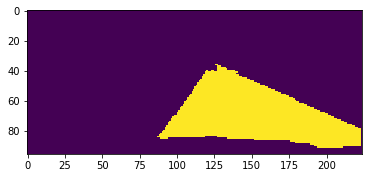

In [23]:
plt.imshow(y[1])

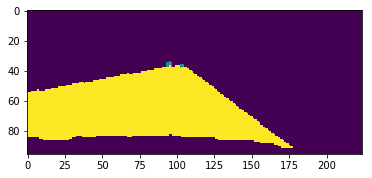

In [120]:
plt.imshow(y)

In [25]:
x_out = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


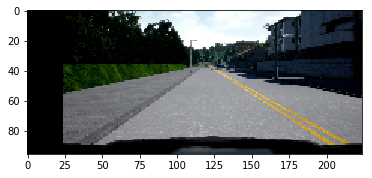

In [26]:
plt.imshow(x_out)

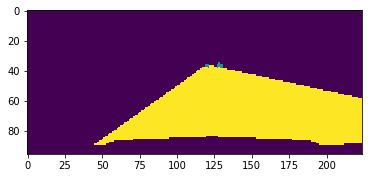

In [27]:
plt.imshow(y)

## U-net (ish)

In [22]:
from torchvision.models import vgg11_bn

In [23]:
def vgg11(pre): return children(vgg11_bn(pre))[0]

In [24]:
model_meta = {
    resnet18:[8,6], resnet34:[8,6], resnet50:[8,6], resnet101:[8,6], resnet152:[8,6],
    vgg11:[0,13], vgg16:[0,22], vgg19:[0,22],
    resnext50:[8,6], resnext101:[8,6], resnext101_64:[8,6],
    wrn:[8,6], inceptionresnet_2:[-2,9], inception_4:[-1,9],
    dn121:[0,7], dn161:[0,7], dn169:[0,7], dn201:[0,7],
}

In [25]:
def get_base(f):
    cut,lr_cut = model_meta[f]
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers), lr_cut

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [28]:
class Unet34(nn.Module):
    def __init__(self, f=resnet34):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 2, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
class Unet11(nn.Module):
    def __init__(self, f=vgg11):
        super().__init__()
        m_base, lr_cut = get_base(f)
        self.rn = m_base
        self.lr_cut = lr_cut
        self.sfs = [SaveFeatures(self.rn[0][i]) for i in [2,6,13,20,27]]
        self.up0 = UnetBlock(512,512,256)
        self.up1 = UnetBlock(256,512,256)
        self.up2 = UnetBlock(256,256,256)
        self.up3 = UnetBlock(256,128,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5  = nn.Conv2d(256,3,1)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up0(x, self.sfs[4].features)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [30]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [model.lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [31]:
def car_f_p_r(pred, targs):
    p2 = F.sigmoid(pred)
    return fbeta_score(targs[:,0,:,:], p2[:,0,:,:], beta=2, threshold=0.5)

In [32]:
def rd_f(pred, targs):
    mx,idx = torch.max(pred, 1)
    p2 = F.sigmoid(pred)
    f,p,r = fbeta_score(targs[:,1,:,:], p2[:,1,:,:], beta=0.5, threshold=0.5)
    return f

In [33]:
def fbeta_score(y_true, y_pred, beta, threshold=None, eps=1e-9):
    beta2 = beta**2

    if threshold:
        y_pred = torch.ge(y_pred.float(), threshold).float()
    else:
        y_pred = y_pred.float()
    y_true = y_true.float()

    true_positive = (y_pred * y_true).sum()
    precision = true_positive/(y_pred.sum()+(eps))
    recall = true_positive/(y_true.sum()+eps)
    
    fb = (precision*recall)/(precision*beta2 + recall + eps)*(1+beta2)
    
    return fb, precision, recall

In [34]:
def new_acc(pred, targs):
    p2 = F.sigmoid(pred)
    return ((p2>0.5).long() == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [35]:
def dice_coeff_weight(pred, target, weight):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2)
    w = V(torch.cuda.FloatTensor(weight).view(1,-1,1))
    i_w = (w*intersection).sum()
    m1_w = (w*m1).sum()
    m2_w = (w*m2).sum()
    return (2. * i_w + smooth) / (m1_w + m2_w + smooth)

def dice_coeff(pred, target):
    smooth = 1.
    num,c,h,w = pred.shape
    m1 = pred.view(num, c, -1)  # Flatten
    m2 = target.view(num, c, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)


class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, logits, targets):
        probs = F.sigmoid(logits)
        num = targets.size(0)  # Number of batches

        if self.weight:
            score = dice_coeff_weight(probs, targets.float(), self.weight)
        else:
            score = dice_coeff(probs, targets.float())
        score = 1 - score.sum() / num
        return score

In [36]:
def get_learner(md, m_fn=Unet34):
    m = to_gpu(m_fn())
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    class_weights = torch.FloatTensor([1,3,2]).cuda()
    learn.crit=nn.CrossEntropyLoss(weight=class_weights)
    learn.crit=SoftDiceLoss(weight=[1,1/100])
    learn.metrics=[new_acc, rd_f, car_f_p_r]
    return learn

### Settings

In [51]:
ext = '-150'
sz = 96
bs = 128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, use_val)

learn = get_learner(md)

Val x:300, y:300
Trn x:6980, y:6980
All x:7280


In [239]:
# learn.load('600urn-19-weights-26-r8')

In [241]:
# learn.half()

In [52]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.998362   0.999773   0.366118   0.0        0.067139   0.014324   1.0       



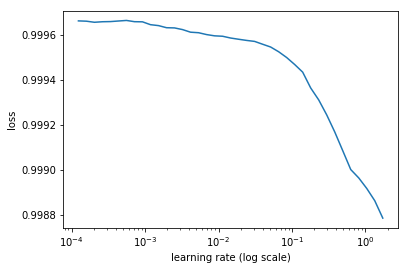

In [53]:
learn.lr_find()
learn.sched.plot()

In [224]:
# trn_it = iter(md.trn_dl)

# x,y = next(trn_it)
# print(y[:,0,:,:].sum(), y[:,1,:,:].sum(), 64*96*224)
# print(15017/1376256, 378405/1376256)

In [54]:
lr=1e-1
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [55]:
learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.997003   0.997242   0.633861   0.329796   0.09264    0.216837   0.081513  
    1      0.996557   0.999089   0.595767   0.309637   0.128247   0.042756   0.272095  
    2      0.996494   0.999665   0.575179   0.344185   0.060602   0.014669   0.320756  
    3      0.996317   0.999117   0.714589   0.43424    0.142235   0.042374   0.373392  
    4      0.996253   0.999761   0.356632   0.379634   0.067139   0.014324   1.0       
    5      0.996192   0.997593   0.773143   0.452081   0.201725   0.142217   0.227464  
    6      0.996156   0.996066   0.744589   0.414087   0.238683   0.405009   0.223221  
    7      0.996121   0.996144   0.745604   0.415128   0.228159   0.389477   0.210186  
    8      0.995793   0.997029   0.811228   0.497687   0.200945   0.210067   0.202298  
    9      0.995075   0.996776   0.832047   0.513882   0.064908   0.65521    0.053156  
    10     0.994699   0.995989   0.829145   0.5076   

[array([0.99344]),
 0.9459822193781535,
 0.796393186597051,
 0.6052814112917422,
 0.7928224075956761,
 0.5747362280759105]

In [56]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [60]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [61]:
learn.unfreeze()
learn.bn_freeze(True)

In [62]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [63]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.99378    0.992001   0.977814   0.922902   0.725086   0.841178   0.702153  
    1      0.993595   0.991908   0.982743   0.950758   0.781226   0.784858   0.785782  
    2      0.993475   0.991479   0.985506   0.963095   0.789778   0.864743   0.773478  
    3      0.993395   0.991398   0.985601   0.960079   0.805665   0.869571   0.791354  
    4      0.993322   0.991361   0.987263   0.96618    0.82052    0.854861   0.812655  
    5      0.993278   0.991268   0.987113   0.96822    0.819093   0.88295    0.804637  
    6      0.993255   0.991304   0.987633   0.96683    0.831605   0.856452   0.826135  
    7      0.993234   0.991255   0.98724    0.969431   0.808166   0.904937   0.787332  
    8      0.993231   0.991255   0.987757   0.967241   0.830459   0.872182   0.82085   
    9      0.993217   0.991205   0.988442   0.967886   0.830465   0.883852   0.818219  


[array([0.9912]),
 0.9884416802724203,
 0.9678858447133988,
 0.8304649345454839,
 0.8838521047701999,
 0.8182185910271067]

In [64]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.99324    0.99124    0.987433   0.971751   0.811542   0.904725   0.791414  
    1      0.993197   0.991205   0.988371   0.973763   0.842705   0.863668   0.837715  
    2      0.99319    0.991195   0.987609   0.968724   0.835076   0.883996   0.824006  
    3      0.993183   0.991174   0.989699   0.972239   0.848151   0.865063   0.844237  
    4      0.993154   0.991146   0.989317   0.973664   0.82666    0.908861   0.808403  
    5      0.993128   0.991083   0.989806   0.975862   0.854688   0.882534   0.848092  
    6      0.993113   0.991076   0.988487   0.976459   0.843249   0.905219   0.829121  
    7      0.993085   0.991076   0.990196   0.975076   0.852062   0.889266   0.843304  
    8      0.993072   0.991059   0.990193   0.976505   0.844136   0.90719    0.829766  
    9      0.993056   0.991055   0.989792   0.976388   0.850512   0.899634   0.839121  


[array([0.99106]),
 0.9897918812433879,
 0.9763884901714008,
 0.8505124569883895,
 0.8996336283669419,
 0.8391209850291219]

In [65]:
learn.save(f'128urn-{S_PREFIX}-0')

In [89]:
learn.load(f'128urn-{S_PREFIX}-0')

In [71]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [72]:
# py = np.argmax(py,1)

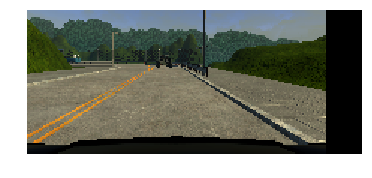

In [73]:
show_img(denorm(x[0]))

In [75]:
py.shape

(128, 2, 96, 224)

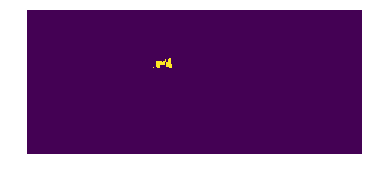

In [76]:
show_img(py[0][0]>0.5);

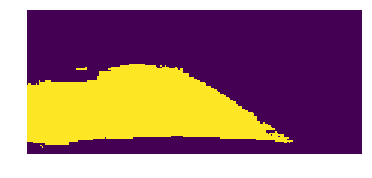

In [77]:
show_img(py[0][1]>0.5);

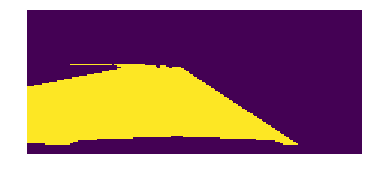

In [80]:
show_img(y[0][1]);

## 256x256

In [59]:
ext = '-300'
sz=192
bs=128
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, use_val)

Val x:300, y:300
Trn x:6980, y:6980
All x:7280


In [60]:
lr=2e-2
wd=1e-6

lrs = np.array([lr/200,lr/20,lr])/2

In [54]:
import gc
gc.collect()

1822

In [61]:
learn = get_learner(md)

In [56]:
learn.load(f'128urn-{S_PREFIX}-0')

In [91]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.986239   0.999507   0.370078   0.269208   0.070503   0.015465   0.901761  


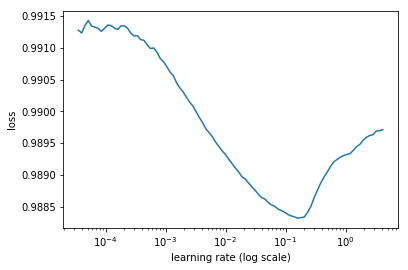

In [92]:
learn.lr_find()
learn.sched.plot()

In [93]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

In [58]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [62]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [63]:
learn.unfreeze()
learn.bn_freeze(True)

In [64]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.993253   0.992125   0.986411   0.955793   0.780462   0.791336   0.795493  
    1      0.993176   0.991802   0.989904   0.973678   0.812399   0.809841   0.826161  
    2      0.993085   0.991334   0.990528   0.977578   0.816599   0.875465   0.805084  
    3      0.993036   0.991149   0.991117   0.981606   0.830091   0.90133    0.814337  
    4      0.992981   0.991091   0.991785   0.983334   0.825837   0.922473   0.804807  
    5      0.992953   0.991022   0.992156   0.985417   0.859425   0.894465   0.851403  
    6      0.99293    0.991025   0.993193   0.985102   0.85244    0.90297    0.84105   
    7      0.992943   0.991051   0.993299   0.985423   0.858625   0.891649   0.851635  


[array([0.99105]),
 0.9932990662256876,
 0.9854231257414555,
 0.8586254445279057,
 0.8916493536585068,
 0.8516346325770857]

In [66]:
learn.fit(lrs/8,1,wds=wd, cycle_len=8,use_clr=(20,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.992907   0.991011   0.993362   0.985283   0.857776   0.899836   0.848358  
    1      0.992914   0.991152   0.993191   0.986707   0.865715   0.867408   0.868749  
    2      0.992893   0.990898   0.993041   0.987242   0.849993   0.94523    0.829161  
    3      0.992862   0.990918   0.993812   0.982465   0.866016   0.914792   0.854838  
    4      0.992843   0.990852   0.993904   0.985883   0.869147   0.929561   0.855266  
    5      0.992824   0.990823   0.994259   0.987328   0.870386   0.938256   0.854951  
    6      0.9928     0.99086    0.99404    0.988184   0.88753    0.905993   0.883353  
    7      0.992801   0.990795   0.994457   0.98768    0.883828   0.926468   0.8738    


[array([0.99079]),
 0.9944568904240926,
 0.9876796452369004,
 0.8838279716841555,
 0.9264677133668846,
 0.8737995957089914]

In [67]:
learn.save(f'256urn-{S_PREFIX}')

In [75]:
learn.load(f'256urn-{S_PREFIX}')

In [68]:
x,y = next(iter(md.trn_dl))

In [77]:
x.shape

torch.Size([64, 3, 192, 416])

In [69]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:32])))

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [79]:
py = np.argmax(py,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


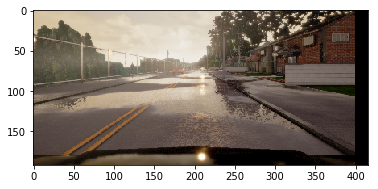

In [80]:
plt.imshow(denorm(x[-1]))

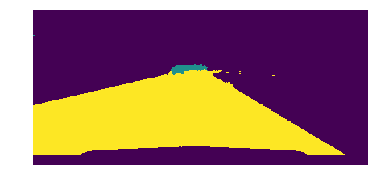

In [81]:
show_img(py[-1]);

In [82]:
py[-1].shape

(192, 416)

In [83]:
y[-1].shape

torch.Size([192, 416])

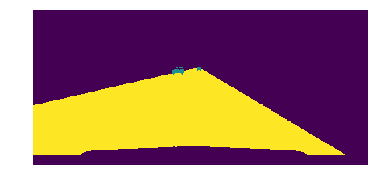

In [84]:
show_img(y[-1]);

## 512x512

In [37]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=24
md = torch_loader(ext, PATH, bs, sz, workers, random_crop, pseudo_label, use_val)

learn = get_learner(md)

Val x:300, y:300
Trn x:6980, y:6980
All x:7280


 94%|█████████▍| 96/102 [00:53<00:03,  1.79it/s, loss=1.97] 

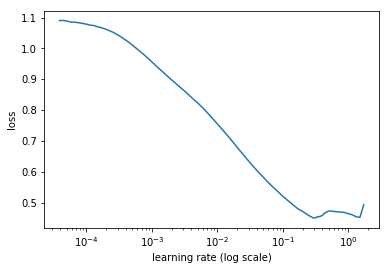

In [124]:
learn.lr_find()
learn.sched.plot()

In [38]:
learn.load(f'256urn-{S_PREFIX}')

In [39]:
learn.freeze_to(1)

In [40]:
lr=5e-3
wd=5e-7

In [41]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.963191   0.962542   0.987505   0.953196   0.797287   0.818309   0.812159  
    1      0.962453   0.961046   0.993176   0.988853   0.80006    0.895037   0.782166  
    2      0.961842   0.959715   0.994043   0.989594   0.8557     0.912854   0.8431    
    3      0.961475   0.959776   0.993646   0.990876   0.871037   0.913039   0.862779  



[array([0.95978]),
 0.9936461758613586,
 0.9908755475636385,
 0.8710369060220335,
 0.9130394362236678,
 0.8627794137594667]

In [43]:
learn.fit(lr/2,1, wds=wd, cycle_len=4,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.962523   0.966457   0.984589   0.972276   0.783896   0.652636   0.874944  
    1      0.961878   0.960871   0.992416   0.987673   0.828914   0.878626   0.821703  
    2      0.961301   0.959718   0.994844   0.985518   0.872623   0.914038   0.864344  
    3      0.96127    0.959841   0.993748   0.989894   0.879325   0.906139   0.875481  



[array([0.95984]),
 0.9937475872039795,
 0.9898943849179642,
 0.8793254858530617,
 0.9061389580249471,
 0.8754812580901415]

In [44]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [42]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [45]:
learn.unfreeze()
learn.bn_freeze(True)

In [46]:
lrs = np.array([lr/200,lr/20,lr])/2

In [47]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.961096   0.95964    0.995266   0.990789   0.891556   0.903781   0.891557  
    1      0.960942   0.95952    0.995247   0.991326   0.886931   0.920245   0.881711  
    2      0.961044   0.959203   0.995222   0.99131    0.89615    0.922763   0.891319  
    3      0.960856   0.959272   0.995384   0.991142   0.889838   0.929034   0.882387  



[array([0.95927]),
 0.9953840088844299,
 0.9911418818223249,
 0.889838134607726,
 0.9290339457579766,
 0.8823874444168008]

In [49]:
learn.fit(lrs/40,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.960969   0.959212   0.995367   0.991279   0.892416   0.928374   0.885806  
    1      0.961013   0.959173   0.99544    0.991239   0.891128   0.932189   0.882968  
    2      0.961021   0.959187   0.99538    0.991351   0.889714   0.933707   0.880979  
    3      0.960969   0.959181   0.995362   0.9914     0.892418   0.930267   0.88498   



[array([0.95918]),
 0.9953624439239502,
 0.9914004798748904,
 0.8924177144506632,
 0.9302668791344244,
 0.8849797439514744]

In [50]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.sched.plot_loss()

### No Crop

In [51]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'

ext = ''
sz=384
bs=16
md = torch_loader(ext, PATH, bs, sz, workers, False, pseudo_label, use_val)

learn = get_learner(md)

Val x:300, y:300
Trn x:6980, y:6980
All x:7280


In [52]:
learn.load(f'600urn-{S_PREFIX}')

In [53]:
learn.unfreeze()
learn.bn_freeze(True)

In [54]:
lr=4e-3
wd=5e-7
lrs = np.array([lr/200,lr/20,lr])/2

In [55]:
learn.fit(lrs/2,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    rd_f       car_f_p_r  
    0      0.938134   0.940727   0.995829   0.992728   0.903904   0.897295   0.908973  
    1      0.937831   0.939975   0.99645    0.991963   0.908376   0.932524   0.903958  
    2      0.937647   0.940041   0.996412   0.993029   0.921029   0.91111    0.925242  
    3      0.937548   0.940047   0.996607   0.992881   0.918995   0.91362    0.922304  



[array([0.94005]),
 0.9966073926289877,
 0.9928807269243927,
 0.9189950280970218,
 0.9136199425973796,
 0.922303617286688]

In [48]:
learn.fit(lrs/20,1, wds=wd,cycle_len=4,use_clr=(20,2))

epoch      trn_loss   val_loss   new_acc                      
    0      0.017155   0.013198   0.995774  
    1      0.017275   0.01323    0.995526                     
    2      0.016587   0.013032   0.995687                     
    3      0.016331   0.013088   0.995593                     



[array([0.01309]), 0.9955930423736572]

In [56]:
learn.save(f'600urn-{S_PREFIX}-nocrop')

### Visualize Results

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x[:10])))

In [ ]:
# py = np.argmax(py,1)

In [ ]:
plt.imshow(denorm(x[8]))

In [ ]:
show_img(py[8][0]>0);

In [ ]:
show_img(py[8][1]>0);

In [ ]:
py[-1].shape

In [ ]:
y[-1].shape

In [ ]:
show_img(y[8]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()